<a href="https://colab.research.google.com/github/arianza1210/ComputerVision/blob/main/latihancnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Soedirman-Machine-Learning/rice-varieties-classification/trunk/data > /dev/null

Program ini dibuat untuk membedakan 3 varietas beras yaitu :

1.   Varietas Beras Basmathi
2.   Varietas Beras IR 64
3.   Varietas Beras Ketan

Pada program ini menggunakan metode *Convolutional Neural Network* (CNN) untuk melakukan klasifikasinya.

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
!ls data/image/train/IR64


I10.jpg  I19.jpg  I27.jpg  I35.jpg  I43.jpg  I51.jpg  I5.jpg   I68.jpg	I7.jpg
I11.jpg  I1.jpg   I28.jpg  I36.jpg  I44.jpg  I52.jpg  I60.jpg  I69.jpg	I8.jpg
I12.jpg  I20.jpg  I29.jpg  I37.jpg  I45.jpg  I53.jpg  I61.jpg  I6.jpg	I9.jpg
I13.jpg  I21.jpg  I2.jpg   I38.jpg  I46.jpg  I54.jpg  I62.jpg  I70.jpg
I14.jpg  I22.jpg  I30.jpg  I39.jpg  I47.jpg  I55.jpg  I63.jpg  I71.jpg
I15.jpg  I23.jpg  I31.jpg  I3.jpg   I48.jpg  I56.jpg  I64.jpg  I72.jpg
I16.jpg  I24.jpg  I32.jpg  I40.jpg  I49.jpg  I57.jpg  I65.jpg  I73.jpg
I17.jpg  I25.jpg  I33.jpg  I41.jpg  I4.jpg   I58.jpg  I66.jpg  I74.jpg
I18.jpg  I26.jpg  I34.jpg  I42.jpg  I50.jpg  I59.jpg  I67.jpg  I75.jpg


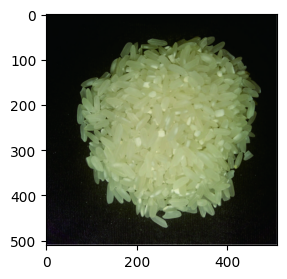

In [ ]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/image/train/IR64/I17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [ ]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('data/image/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Basmathi', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 180 images belonging to 3 classes.
Found 45 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (45, 224, 224, 3) (45, 3)
Bentuk array dari dataset test (pengujian) adalah: (45, 224, 224, 3) (45,)


In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Basmathi': 0, 'IR64': 1, 'Ketan': 2}


In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
#cetak topologi model
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test,y_test2)

In [ ]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
2/2 [==============================] - 13s 7s/step - loss: 6.7923 - acc: 0.3000 - val_loss: 3.1369 - val_acc: 0.3333
Epoch 2/100
2/2 [==============================] - 9s 6s/step - loss: 1.2399 - acc: 0.5778 - val_loss: 0.4845 - val_acc: 0.6889
Epoch 3/100
2/2 [==============================] - 10s 4s/step - loss: 0.5694 - acc: 0.7278 - val_loss: 0.9656 - val_acc: 0.4667
Epoch 4/100
2/2 [==============================] - 9s 6s/step - loss: 0.5730 - acc: 0.6722 - val_loss: 0.3927 - val_acc: 0.8000
Epoch 5/100
2/2 [==============================] - 9s 6s/step - loss: 0.3647 - acc: 0.7833 - val_loss: 0.3447 - val_acc: 0.8444
Epoch 6/100
2/2 [==============================] - 10s 6s/step - loss: 0.3666 - acc: 0.7833 - val_loss: 0.2728 - val_acc: 0.9111
Epoch 7/100
2/2 [==============================] - 9s 6s/step - loss: 0.2336 - acc: 0.9444 - val_loss: 0.1821 - val_acc: 0.9778
Epoch 8/100
2/2 [==============================] - 9s 6s/step - loss: 0.1928 - acc: 0.9556 - val_loss

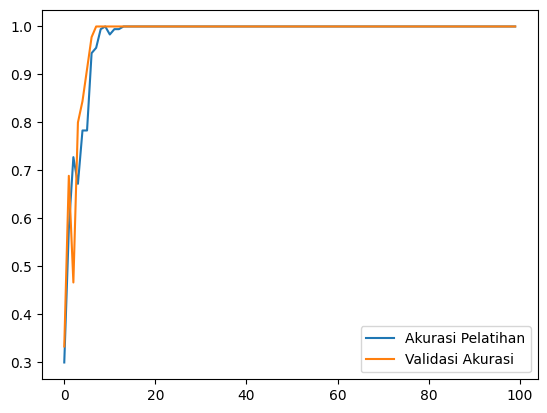

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

In [ ]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [9.9999917e-01 7.7966206e-07 3.5673401e-13]


In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))


['loss', 'acc']
2/2 [==============================] - 2s 442ms/step - loss: 7.5801e-04 - acc: 1.0000
[0.0007580132223665714, 1.0]


In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


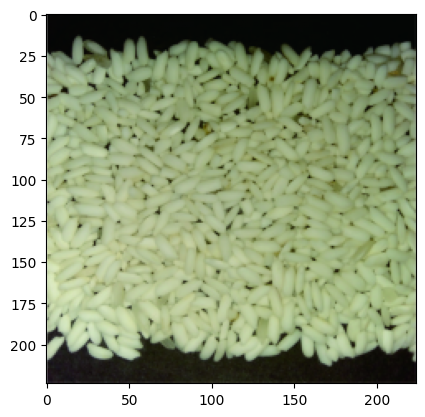

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [4.2745175e-08 3.5999820e-04 9.9963999e-01]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [ ]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")


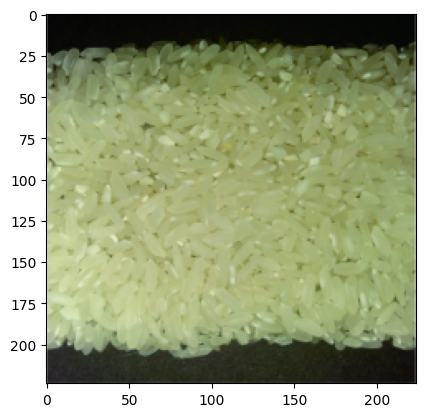

Label yang benar adalah: 1 : IR64
Nilai yang diprediksi adalah: [9.1841182e-05 9.9892527e-01 9.8286220e-04]
Label yang diprediksi adalah: 1 : IR64
Prediksi benar


In [ ]:
n = 22 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")


Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


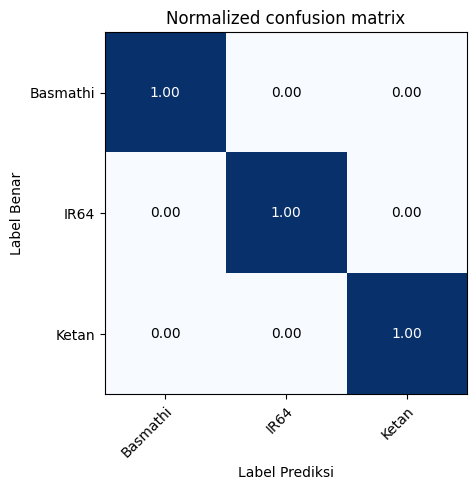

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_3_Varietas_Beras_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets


INFO:tensorflow:Assets written to: save/model/assets


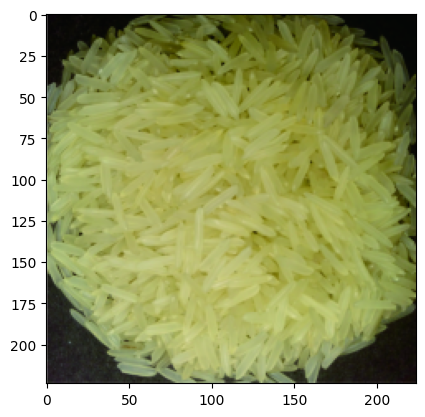

Label yang benar adalah: 0 : Basmathi
Nilai yang diprediksi adalah: [1.00e+00 1.44e-09 3.46e-17]
Label yang diprediksi adalah: 0 : Basmathi
Prediksi benar


In [ ]:
n = 10 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

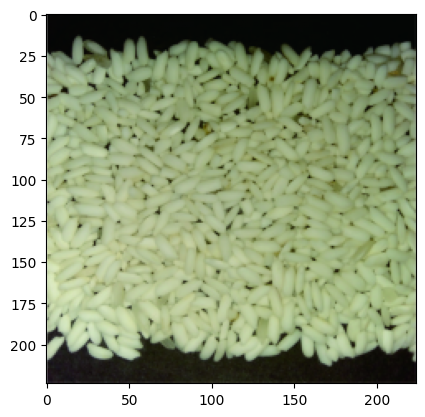

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [4.27e-08 3.60e-04 1.00e+00]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [ ]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")


In [ ]:
print (X_test)

[[[[0.47 0.48 0.48]
   [0.22 0.22 0.22]
   [0.22 0.23 0.23]
   ...
   [0.22 0.23 0.23]
   [0.22 0.23 0.23]
   [0.22 0.23 0.23]]

  [[0.34 0.35 0.34]
   [0.02 0.03 0.03]
   [0.02 0.03 0.02]
   ...
   [0.02 0.03 0.02]
   [0.02 0.03 0.02]
   [0.02 0.03 0.03]]

  [[0.35 0.36 0.35]
   [0.02 0.03 0.02]
   [0.02 0.03 0.02]
   ...
   [0.02 0.03 0.02]
   [0.02 0.03 0.02]
   [0.02 0.03 0.03]]

  ...

  [[0.39 0.38 0.38]
   [0.1  0.08 0.1 ]
   [0.1  0.07 0.09]
   ...
   [0.05 0.03 0.04]
   [0.05 0.02 0.03]
   [0.06 0.03 0.03]]

  [[0.4  0.38 0.39]
   [0.1  0.09 0.09]
   [0.09 0.08 0.08]
   ...
   [0.04 0.03 0.02]
   [0.04 0.03 0.03]
   [0.05 0.04 0.03]]

  [[0.42 0.4  0.41]
   [0.13 0.12 0.12]
   [0.14 0.12 0.13]
   ...
   [0.09 0.08 0.06]
   [0.1  0.09 0.07]
   [0.1  0.09 0.07]]]


 [[[0.47 0.48 0.48]
   [0.22 0.22 0.22]
   [0.23 0.23 0.23]
   ...
   [0.22 0.23 0.22]
   [0.23 0.24 0.23]
   [0.28 0.29 0.29]]

  [[0.35 0.35 0.35]
   [0.03 0.03 0.03]
   [0.02 0.03 0.02]
   ...
   [0.02 0.03 0.02]
 

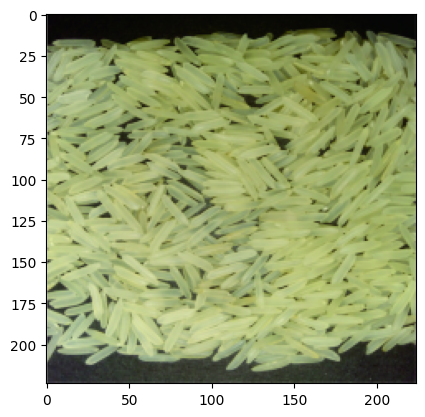

Label yang benar adalah: 0 : Basmathi
Nilai yang diprediksi adalah: [1.00e+00 1.61e-07 1.31e-14]
Label yang diprediksi adalah: 0 : Basmathi
Prediksi benar


In [ ]:
n = 4 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")
